In [1]:
# подключение библиотек
import os
import itertools
from functools import reduce
import threading as thg

import numpy as np
from matplotlib import pyplot as plt
import cv2

from  styles import styles, styles_count

## Задача-1. Байесовская генерация стилей
### 1. Словарь стилей


In [2]:
# класс генерации стилей
class DictStylesGenerator(object):
    def __init__(self, styles: dict, styles_count: dict) -> None:
        self.styles = styles
        self.styles_count = styles_count

        # создаем все возможные пары стилей
        self.samples = np.array(list(itertools.product(*styles.values())))

        # считаем сглаженную вероятность каждого признака в рамках своей группы
        self.__features_probs = list(map(lambda group_counts: (np.array(group_counts) + 1) / 
                                                            (sum(group_counts) + len(group_counts)), 
                                       styles_count.values()))
        
         # вероятности всех возможных стилей
        self.__samples_probs = np.array(list(
                                        map(lambda sample_probs: reduce(lambda cum_prob, feature_prob: cum_prob * feature_prob, 
                                                                        sample_probs, 
                                                                        1),
                                            list(itertools.product(*self.__features_probs)))
                                        )
                                    )
    def __iter__(self) -> object:
        return self
    
    def __next__(self) -> tuple:
        return self.next()
    
    # метод генерации стиля
    def next(self) -> tuple:
        index = np.random.choice(self.samples.shape[0], 1, p=self.__samples_probs)
        style = {key: self.samples[index][0][ind] for ind, key in enumerate(styles.keys())}
        prob = self.__samples_probs[index]
        return (style, prob)

##### Тестирование результата

In [3]:
styles_generator = DictStylesGenerator(styles, styles_count)

In [4]:
next(styles_generator)

({'прическа': 'короткая прямые',
  'цвет волос': 'серебристо серый',
  'аксесуар': 'круглые очки',
  'одежда': 'комбинезон',
  'цвет одежды': 'белый'},
 array([0.00173197]))

### 2. Пиксели изображений

In [9]:
# класс генерации стилей
class ImageStylesGenerator(object):
    
    __channels = ['r', 'g', 'b']

    def __init__(self, images: list) -> None:
        self.images = images
        self.shape = images[0].shape
        self.img_generated = np.zeros(self.shape)
        self.__channels_dist = np.array([[[{}, {}, {}, {}] 
                                        for _ in range(self.shape[1])] 
                                       for _ in range(self.shape[0])])
        
        # посчет частот значений каждого канала пикселя 
        ths = []
        for img in self.images:
            for chl in self.__channels:
                th_i = thg.Thread(target=self.__count_freq, args=(img, chl))    
                th_i.start()
                ths.append(th_i)
            for th in ths:
                th.join()
        
        # посчет вероятностей значений каждого канала пикселя 
        ths = []
        for chl in self.__channels:
            th_i = thg.Thread(target=self.__count_prob, args=(chl))    
            th_i.start()
            ths.append(th_i)
        for th in ths:
            th.join()
            
    # метод определения индекса канала по символьному значению
    @staticmethod
    def _get_channel_index(channel: str) -> int:
        chl_index = -1

        if channel == 'r': chl_index = 0
        elif channel == 'g': chl_index = 1
        elif channel == 'b': chl_index = 2
        elif channel == 'a': chl_index = 3
        else: raise ValueError('wrong channel input')

        return chl_index
    
    # генерация значений пикселей в определенном канале
    def __generate_channel_value(self, channel: str) -> None:
        chl_index = self._get_channel_index(channel)

        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                num_count = len(self.__channels_dist[i][j][chl_index])
                index = np.random.choice(num_count, p=list(self.__channels_dist[i][j][chl_index].values()))
                self.img_generated[i][j][chl_index] = list(self.__channels_dist[i][j][chl_index].keys())[index]

    # метод посчета частот значений каждого канала пикселя
    def __count_freq(self, image: np.ndarray, channel: str) -> None:
        chl_index = self._get_channel_index(channel)
        
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                value = image[i][j][chl_index]
                if value not in self.__channels_dist[i][j][chl_index].keys():
                    self.__channels_dist[i][j][chl_index][value] = 1
                else:
                    self.__channels_dist[i][j][chl_index][value] += 1

    # метод посчета вероятностей значений каждого канала пикселя
    def __count_prob(self, channel: str) -> None:
        chl_index = self._get_channel_index(channel)
        
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                total_count = sum(self.__channels_dist[i][j][chl_index].values())
                for num in self.__channels_dist[i][j][chl_index].keys():
                    self.__channels_dist[i][j][chl_index][num] /= total_count

    def __iter__(self) -> object:
        return self
    
    def __next__(self) -> tuple:
        return self.next()
    
    # метод генерации изображения
    def next(self) -> np.ndarray:
        ths = []
        for chl in self.__channels:
            th_i = thg.Thread(target=self.__generate_channel_value, args=(chl))    
            th_i.start()
            ths.append(th_i)
        for th in ths:
            th.join()

        return self.img_generated

##### Тестирование результата

In [10]:
path = '../avatars/'
images = []

for img_path in os.listdir(path):
    img = cv2.imread(path + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    images.append(img)

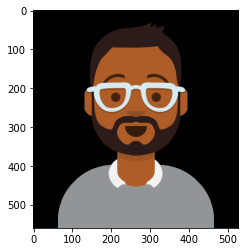

In [11]:
plt.imshow(images[0])

In [12]:
styles_generator = ImageStylesGenerator(images)

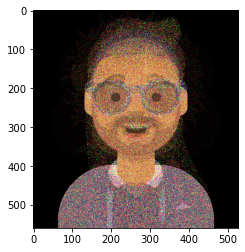

In [13]:
img = next(styles_generator)
plt.imshow(np.uint8(img))

##### Сохранение результатов

In [14]:
path = './generated/'

for i in range(5):
    img = next(styles_generator)
    img = cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2BGR) 
    cv2.imwrite(path + f'avatar_{i + 1}.jpg', img)

In [15]:
!pip freeze > requirements.txt